In [1]:
cd ..

d:\online class\DeepLearning\Object Detection


d:\online class\DeepLearning\Object Detection\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
pwd

'd:\\online class\\DeepLearning\\Object Detection'

In [3]:
## Python in-built tools 
import os
import pickle
## Data Science Tools 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
%matplotlib inline

## Image Processing Tools 
import cv2
from torch.utils.data import Dataset, DataLoader 
import selectivesearch


## Frameworks


Hyper Parameters

In [4]:
image_paths = "data/images/images"
csv_path = "data/df.csv"
batch_size = 2
n_epochs = 10
learning_rate = 1e-4
threshold_iou = 0.5

In [5]:
class OpenImageDataset(Dataset):

    def __init__(self, image_paths, csv_path):
        super().__init__()
        self.image_paths = image_paths
        self.csv_path = csv_path
        self.df = pd.read_csv(csv_path)
        self.unique_images = self.df['ImageID'].unique()

    def __len__(self):
        return len(self.unique_images)
    
    def __getitem__(self, index):
        image_id = self.unique_images[index]
        image_full_path = os.path.join(os.getcwd(), self.image_paths, image_id + ".jpg")
        image = cv2.imread(image_full_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        h, w, _ = image.shape
        df = self.df.loc[self.df['ImageID'] == image_id]

        bboxes = df[['XMin', 'YMin', 'XMax', 'YMax']].values
        bboxes = (bboxes * np.array([w, h, w, h])).astype(np.uint16)

        classes = df['LabelName'].values
        return image, bboxes, classes, image_full_path

datasets = OpenImageDataset(image_paths, csv_path)
#datasets[]

In [6]:
len(datasets)

15225

<function matplotlib.pyplot.show(close=None, block=None)>

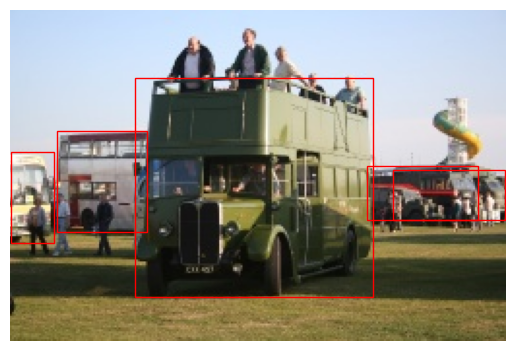

In [7]:
img, bbx, _, _ = datasets[14]
plt.imshow(img)
plt.axis('off')

for bb in bbx:
    rect = patches.Rectangle(bb[:2], bb[2]-bb[0], bb[3]-bb[1], edgecolor = 'r', facecolor = 'none', linewidth = 1)
    plt.gca().add_patch(rect)
plt.show


In [8]:
def extract_candidates(img):
    _, regions = selectivesearch.selective_search(img, scale=100, min_size=50)
    candidates = []
    img_area = np.prod(img.shape[:2])
    for region in regions:
        if region['rect'] in candidates:
            continue
        if region['size'] < 0.05*img_area:
            continue
        if region['size'] > img_area:
            continue 
        candidates.append(region['rect'])
    return candidates

def extract_iou(bbox1, bbox2, epsilon=1e-5):
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])

    width = x2 - x1
    height = y2 - y1

    if width < 0 or height < 0:
        return 0
    
    intersection_area = width * height 
    area_1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    area_2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

    union_area = area_1 + area_2 - intersection_area
    
    return intersection_area / (union_area + epsilon)


In [9]:
FULL_PATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
# N = 100
for i, (image, bboxes, classes, image_full_path) in enumerate(datasets):
    # if i == N:
    #     break

    H, W, _ = image.shape
    candidates = extract_candidates(image)
    candidates = np.array([(x, y, x+w, y+h) for x, y, w, h in candidates])

    clss, deltas, rois = [], [], []
    ious = np.array([[extract_iou(candidate, bbox) for bbox in bboxes] for candidate in candidates])
    
    for j, candidate in enumerate (candidates):
        cx, cy, cX, cY = candidate
        candidate_ious = ious[j]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x, _y, _X, _Y = bboxes[best_iou_at]

        if best_iou > threshold_iou:
            clss.append(classes[best_iou_at])
        else:
            clss.append('background')

        delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W, H, W, H])
        deltas.append(delta)

        rois.append(candidate / np.array([W, H, W, H]))

    FULL_PATHS.append(image_full_path)
    GTBBS.append(bboxes)
    CLSS.append(clss)
    DELTAS.append(deltas)
    ROIS.append(rois)
    IOUS.append(ious)


d:\online class\DeepLearning\Object Detection\venv\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
d:\online class\DeepLearning\Object Detection\venv\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
d:\online class\DeepLearning\Object Detection\venv\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to 

In [10]:

def save_pickle(obj, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)
        
def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)
        
save_pickle(FULL_PATHS, 'paths.pkl')
save_pickle(GTBBS, 'gtbbs.pkl')
save_pickle(CLSS, 'clss.pkl')   
save_pickle(DELTAS, 'deltas.pkl')
save_pickle(ROIS, 'rois.pkl')
save_pickle(IOUS, 'ious.pkl')

F_PATH = load_pickle('paths.pkl')
F_PATH

['d:\\online class\\DeepLearning\\Object Detection\\data/images/images\\0000599864fd15b3.jpg',
 'd:\\online class\\DeepLearning\\Object Detection\\data/images/images\\00006bdb1eb5cd74.jpg',
 'd:\\online class\\DeepLearning\\Object Detection\\data/images/images\\00010bf498b64bab.jpg',
 'd:\\online class\\DeepLearning\\Object Detection\\data/images/images\\00013f14dd4e168f.jpg',
 'd:\\online class\\DeepLearning\\Object Detection\\data/images/images\\0002914fa805e227.jpg',
 'd:\\online class\\DeepLearning\\Object Detection\\data/images/images\\00036603fa39fa85.jpg',
 'd:\\online class\\DeepLearning\\Object Detection\\data/images/images\\0004d5a9dd44ab6a.jpg',
 'd:\\online class\\DeepLearning\\Object Detection\\data/images/images\\0005f203463a13a8.jpg',
 'd:\\online class\\DeepLearning\\Object Detection\\data/images/images\\00066517f9d814f9.jpg',
 'd:\\online class\\DeepLearning\\Object Detection\\data/images/images\\00072b81abc72d21.jpg',
 'd:\\online class\\DeepLearning\\Object Detection